# 2D prediction for the entire Kevitsa deposit

In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import numpy as np 
import pandas as pd 
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
two_composite_filtered = pd.read_csv("Curated_data/two_composite_filtered.csv", low_memory=False)

- Iteration 0, MSE : 0.28
- Iteration 100, MSE : 0.00
- Iteration 200, MSE : 0.00
- Iteration 300, MSE : 0.00
- Iteration 400, MSE : 0.00
- Iteration 500, MSE : 0.00
- Iteration 600, MSE : 0.00
- Iteration 700, MSE : 0.00
- Iteration 800, MSE : 0.00
- Iteration 900, MSE : 0.00


C:\Users\23478671\AppData\Local\Temp\ipykernel_31524\2858341112.py:82: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(contour_hole, label=mineral)


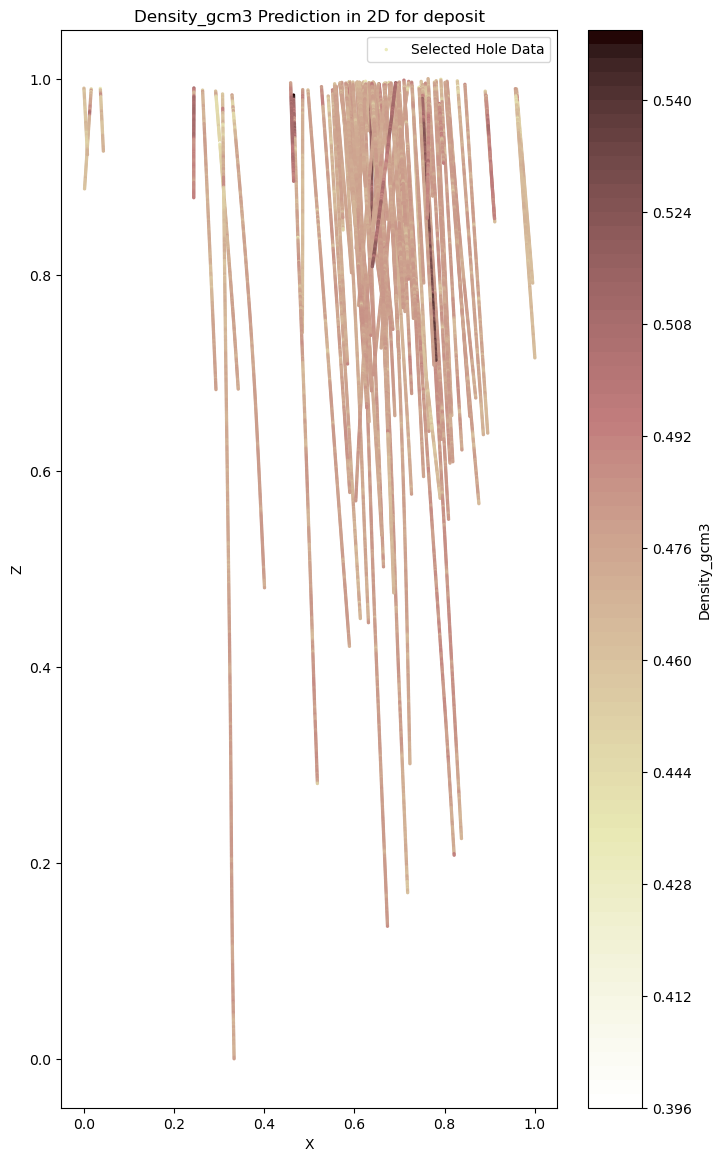

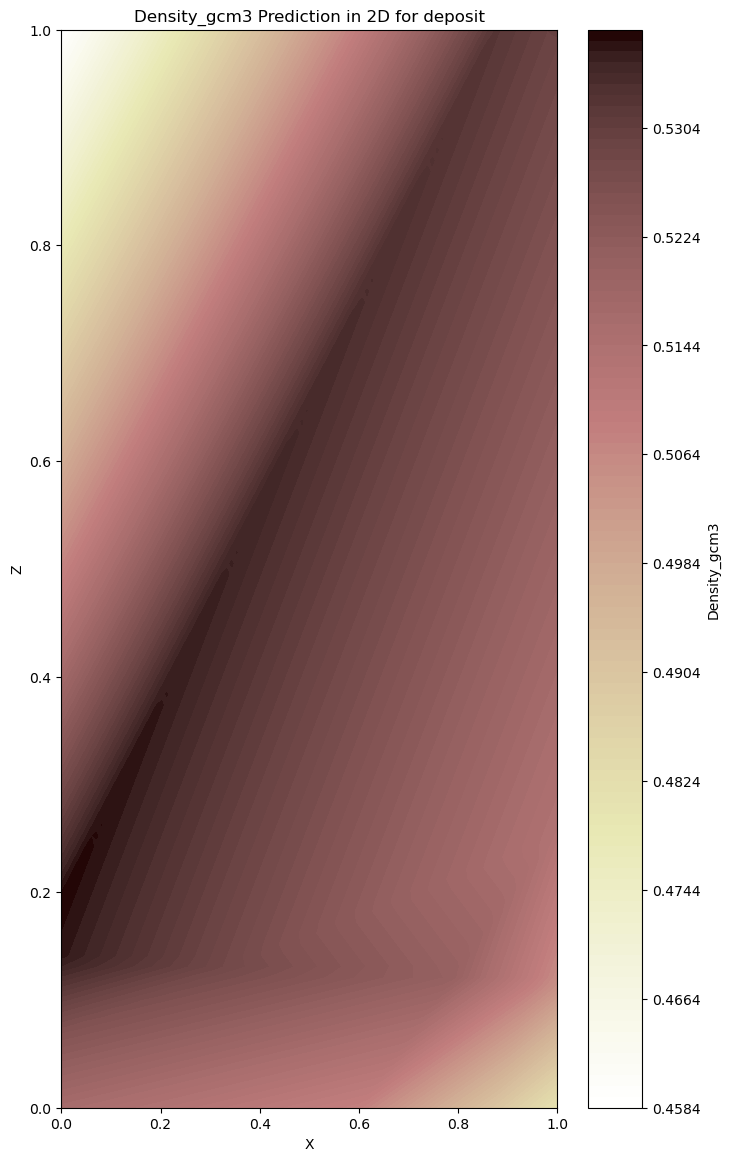

In [30]:
from sklearn.preprocessing import MinMaxScaler
mineral = 'Density_gcm3'
two_composite_1mineral = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
two_composite_1mineral = two_composite_1mineral.dropna(subset=[mineral])
    
  
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Define the columns to normalize
columns_to_normalize = ['X','Y', 'Z', mineral]  # Add all columns you want to normalize

# Fit the scaler to your data and transform the specified columns
two_composite_1mineral[columns_to_normalize] = scaler.fit_transform(two_composite_1mineral[columns_to_normalize])


x = two_composite_1mineral[['X', 'Z']].values  # Use X and Y coordinates
y = two_composite_1mineral[mineral].values[:, np.newaxis]  # Keep mineral as the output
x = x.reshape(len(two_composite_1mineral),2)

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

model = nn.Sequential(
nn.Linear(in_features=2, out_features=20),  
nn.ReLU(),
nn.Linear(in_features=20, out_features=1)
)

mse_loss = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

for step in range(1000):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse 
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if step % 100 == 0:
        print('- Iteration %d, MSE : %2.2f' % (step, mse.item()))



# Define a grid of points for prediction
x_grid_hole = np.linspace(x[:, 0].min(), x[:, 0].max(), 100)
y_grid_hole = np.linspace(x[:, 1].min(), x[:, 1].max(), 100)
xv_hole, yv_hole = np.meshgrid(x_grid_hole, y_grid_hole)
xy_grid_hole = np.c_[xv_hole.ravel(), yv_hole.ravel()]

# Make predictions for the grid
predictions_hole = model(torch.tensor(xy_grid_hole, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions_hole = predictions_hole.data.numpy().reshape(xv_hole.shape)



# Optionally, you can scatter plot the data points for this specific hole
plt.figure(figsize=(8, 14))

plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=y.data.numpy(), cmap='pink_r', s=2, label='Selected Hole Data')

plt.colorbar(contour_hole, label=mineral)
plt.legend()
plt.xlabel('X')
plt.ylabel('Z')
plt.title(f'{mineral} Prediction in 2D for deposit')
plt.show()

# Plot the contour plot of the mineral predictions for the selected hole
plt.figure(figsize=(8, 14))
contour_hole = plt.contourf(xv_hole, yv_hole, predictions_hole, cmap='pink_r', levels=100)  # Adjust levels as needed

plt.colorbar(contour_hole, label=mineral)
plt.xlabel('X')
plt.ylabel('Z')
plt.title(f'{mineral} Prediction in 2D for deposit')
plt.show()



In [ ]:
import matplotlib.pyplot as plt

# Extract the X and Y coordinates
x_y_data = two_composite_1mineral[['X', 'Y']]

# Create a scatter plot of the X and Y coordinates
plt.figure(figsize=(14, 8))
plt.scatter(x_y_data['X'], x_y_data['Y'], s=4)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('X and Y Coordinates')
plt.show()